# Model for predicting Second Language Adquisiton

We start by loading the necessary libraries.

In [12]:
import transformers
transformers.__version__

'4.18.0'

In [1]:
from fastai.data.all import *
from fastai.learner import *
from fastai.losses import CrossEntropyLossFlat
from fastai.optimizer import Adam, OptimWrapper, params
from fastai.metrics import accuracy, F1Score
from fastai.torch_core import *
from fastai.torch_imports import *
from transformers import AutoModelForSequenceClassification
import pandas as pd
from blurr.text.data.core import *
from blurr.text.modeling.core import *
from blurr.text.utils import NLP
from datasets import load_dataset, concatenate_datasets

/home/jonathan/.virtualenvs/huggingface/lib/python3.6/site-packages/torchaudio/backend/utils.py:54: UserWarning: "sox" backend is being deprecated. The default backend will be changed to "sox_io" backend in 0.8.0 and "sox" backend will be removed in 0.9.0. Please migrate to "sox_io" backend. Please refer to https://github.com/pytorch/audio/issues/903 for the detail.
  '"sox" backend is being deprecated. '


In [2]:
import torch
torch.cuda.set_device(0)

Now, we load the train and validation sets.

In [3]:
train_df = pd.read_csv('perplejidad/datasets/train_train_set.csv',delimiter='\t')

In [4]:
valid_df = pd.read_csv('perplejidad/datasets/validation_train_set.csv',delimiter='\t')

In [5]:
len(train_df),len(valid_df)

(33684, 3743)

In [6]:
train_df['is_valid']=False

In [7]:
valid_df['is_valid']=True

In [8]:
train_valid_df = pd.concat([train_df,valid_df])

We define the indexes for training and validation.

In [9]:
train_idxs, valid_idxs = L(range(len(train_valid_df[train_valid_df.is_valid==False]))), L(range(len(train_valid_df[train_valid_df.is_valid==False]), len(train_valid_df)))

Now, we can define the model. In this case, we use a predefined model called Roberta.

In [10]:
np.unique(train_valid_df.Level)

array(['A1', 'A2', 'B1', 'B2', 'C1'], dtype=object)

In [11]:
model_cls = AutoModelForSequenceClassification
pretrained_model_name = "bigscience/bloom-1b3"
hf_arch, hf_config, hf_tokenizer,hf_model = NLP.get_hf_objects(
    pretrained_model_name,model_cls= model_cls, config_kwargs={"num_labels": 5}
)

hf_arch, type(hf_config), type(hf_tokenizer),type(hf_model)

KeyError: 'bloom'

In [10]:
dl_kwargs = {"bs": 64, "val_bs": 64}
learn_kwargs = {"metrics": [accuracy]}

In [14]:
learn = BlearnerForSequenceClassification.from_data(
    train_valid_df,
    "bigscience/bloom-1b3",
    text_attr="Sentence",
    label_attr="Level",
    dblock_splitter=IndexSplitter(valid_idxs),
    dl_kwargs=dl_kwargs,
    learner_kwargs=learn_kwargs,
)

Downloading:   0%|          | 0.00/694 [00:00<?, ?B/s]

KeyError: 'bloom'

In [12]:
learn = learn.to_fp16()

In [13]:
learn.dls.show_batch(dataloaders=learn.dls, trunc_at=500, max_n=5)

,text,target
0,"aquí es mi número de teléfono + : + 18270918681 +. + por _ favor teléfono + : + 18270918681 +. + por _ favor teléfono + : + 18270918681 +. + por _ favor teléfono + : + 18270918681 +. + por _ favor teléfono + : + 18270918681 +. + por _ favor, puede llamar me por eso.",B1
1,"visitamos a muchos lugares muy interesantes como las mezquitas sultan _ ayub y achakirine, topkapi etc... mi lugar preferido fue la mezquita _ de _ sultan _ ayub : sentí cosas que no puedo describir te.",A2
2,"regi, solamente llegaré a casa por volta de la una _ y _ media por que la película retrasó mucho para empezar, y entonces, solamente terminará a la una _ hora _ de _ la _ mañana, por _ favor, no te preocupes.",A1
3,"durante el fin de semana pasado, en _ medio _ de el descanso de 5 dias debido _ a la celebracion de el dia _ de _ accion _ de _ gracias, fuimos un grupo de 11 personas a la casa de mis padres en wisconsin.",C1
4,"lo que me gustó mas fueran las visitas en la parte vieja de la ciudad, la descoberta de la arquitectura, la italiana, las pasajens pedestres de una rua para una otra, atraversando las casas ( las",A2


In [14]:
learn.fine_tune(10,1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,0.953426,0.901619,0.651082,00:31


epoch,train_loss,valid_loss,accuracy,time
0,0.695642,0.676943,0.741384,00:50
1,0.577810,0.628538,0.762757,00:51
2,0.486175,0.627879,0.772108,00:52
3,0.345778,0.660044,0.777718,00:52
4,0.252270,0.787121,0.773177,00:52
5,0.134410,0.919224,0.778787,00:52
6,0.069845,1.037823,0.777184,00:52
7,0.077579,1.130261,0.782260,00:52
8,0.045114,1.201705,0.781726,00:53
9,0.043832,1.218270,0.781192,00:49


In [15]:
learn.export('bert.pkl')

In [16]:
learn.save('bert-new')

Path('models/bert-new.pth')

In [17]:
test_df = pd.read_csv('perplejidad/datasets/test_set.csv',delimiter='\t')

In [18]:
test_df['is_valid']=True

In [19]:
len(train_df)

33684

In [20]:
train_test_df = pd.concat([train_df,test_df])

In [21]:
train_idxs, test_idxs = L(range(len(train_test_df[train_test_df.is_valid==False]))), L(range(len(train_test_df[train_test_df.is_valid==False]), len(train_test_df)))

In [22]:
learnTest = BlearnerForSequenceClassification.from_data(
    train_test_df,
    "dccuchile/bert-base-spanish-wwm-uncased",
    text_attr="Sentence",
    label_attr="Level",
    dblock_splitter=IndexSplitter(test_idxs),
    dl_kwargs=dl_kwargs,
    learner_kwargs=learn_kwargs,
)

In [23]:
learnTest.load('bert-new')

In [24]:
learnTest.validate()

(#2) [1.2462292909622192,0.781660795211792]

In [25]:
preds,gt=learnTest.get_preds()

In [26]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [27]:
cm = confusion_matrix(gt, np.argmax(preds,axis=1))

In [28]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=learnTest.dls.vocab)

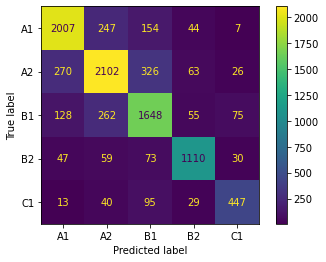

In [29]:
disp.plot()

In [34]:
model = learnTest.hf_model

In [47]:
device = torch.device("cuda:2" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()
model.zero_grad()

In [50]:
def predict(inputs):
    return model(inputs)[0]

In [48]:
from transformers import AutoTokenizer 
tokenizer = AutoTokenizer.from_pretrained("dccuchile/bert-base-spanish-wwm-uncased")

In [49]:
ref_token_id = tokenizer.pad_token_id # A token used for generating token reference
sep_token_id = tokenizer.sep_token_id # A token used as a separator between question and text and it is also added to the end of the text.
cls_token_id = tokenizer.cls_token_id # A token used for prepending to the concatenated question-text word sequence

In [51]:
def construct_input_ref_pair(text, ref_token_id, sep_token_id, cls_token_id):

    text_ids = tokenizer.encode(text, add_special_tokens=False)
    # construct input token ids
    input_ids = [cls_token_id] + text_ids + [sep_token_id]
    # construct reference token ids 
    ref_input_ids = [cls_token_id] + [ref_token_id] * len(text_ids) + [sep_token_id]

    return torch.tensor([input_ids], device=device), torch.tensor([ref_input_ids], device=device), len(text_ids)

def construct_input_ref_token_type_pair(input_ids, sep_ind=0):
    seq_len = input_ids.size(1)
    token_type_ids = torch.tensor([[0 if i <= sep_ind else 1 for i in range(seq_len)]], device=device)
    ref_token_type_ids = torch.zeros_like(token_type_ids, device=device)# * -1
    return token_type_ids, ref_token_type_ids

def construct_input_ref_pos_id_pair(input_ids):
    seq_length = input_ids.size(1)
    position_ids = torch.arange(seq_length, dtype=torch.long, device=device)
    # we could potentially also use random permutation with `torch.randperm(seq_length, device=device)`
    ref_position_ids = torch.zeros(seq_length, dtype=torch.long, device=device)

    position_ids = position_ids.unsqueeze(0).expand_as(input_ids)
    ref_position_ids = ref_position_ids.unsqueeze(0).expand_as(input_ids)
    return position_ids, ref_position_ids
    
def construct_attention_mask(input_ids):
    return torch.ones_like(input_ids)

In [52]:
def custom_forward(inputs):
    preds = predict(inputs)
    return torch.softmax(preds, dim = 1)[0][1].unsqueeze(-1)

In [53]:
from captum.attr import visualization as viz
from captum.attr import IntegratedGradients, LayerConductance, LayerIntegratedGradients
from captum.attr import configure_interpretable_embedding_layer, remove_interpretable_embedding_layer

In [54]:
lig = LayerIntegratedGradients(custom_forward, model.bert.embeddings)

In [55]:
text = "Dos hijas viven con él y la otra en Marseille ."

In [56]:
input_ids, ref_input_ids, sep_id = construct_input_ref_pair(text, ref_token_id, sep_token_id, cls_token_id)
token_type_ids, ref_token_type_ids = construct_input_ref_token_type_pair(input_ids, sep_id)
position_ids, ref_position_ids = construct_input_ref_pos_id_pair(input_ids)
attention_mask = construct_attention_mask(input_ids)

indices = input_ids[0].detach().tolist()
all_tokens = tokenizer.convert_ids_to_tokens(indices)

In [57]:
# Check predict output
predict(input_ids)

tensor([[13.9123, -0.3355, -7.6495, -4.1155, -4.4623]], device='cuda:2',
       grad_fn=<AddmmBackward>)

In [58]:
# Check output of custom_forward
custom_forward(input_ids)

tensor([6.4899e-07], device='cuda:2', grad_fn=<UnsqueezeBackward0>)

In [69]:
attributions, delta = lig.attribute(inputs=input_ids,
                                    baselines=ref_input_ids,
                                    n_steps=700,
                                    internal_batch_size=3,
                                    return_convergence_delta=True)

AssertionError: Cannot choose target column with output shape torch.Size([1]).

In [60]:
def summarize_attributions(attributions):
    attributions = attributions.sum(dim=-1).squeeze(0)
    attributions = attributions / torch.norm(attributions)
    return attributions

In [61]:
attributions_sum = summarize_attributions(attributions)

In [63]:
score = predict(input_ids)


In [64]:
score

tensor([[13.9123, -0.3355, -7.6495, -4.1155, -4.4623]], device='cuda:2',
       grad_fn=<AddmmBackward>)

In [65]:
# storing couple samples in an array for visualization purposes
score_vis = viz.VisualizationDataRecord(attributions_sum,
                                        torch.softmax(score, dim = 1)[0][1],
                                        torch.argmax(torch.softmax(score, dim = 0)[0]),
                                        1,
                                        text,
                                        attributions_sum.sum(),       
                                        all_tokens,
                                        delta)


In [66]:
print('\033[1m', 'Visualization For Score', '\033[0m')
viz.visualize_text([score_vis])

 Visualization For Score 


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
1,0 (0.00),Dos hijas viven con él y la otra en Marseille .,-0.29,[CLS] dos hijas viven con él y la otra en mars ##ei ##lle . [SEP]


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
1,0 (0.00),Dos hijas viven con él y la otra en Marseille .,-0.29,[CLS] dos hijas viven con él y la otra en mars ##ei ##lle . [SEP]
